Bibliotecas usaddas

In [1]:
import os
import pandas as pd
import glob
import gzip
import io
import networkx as nx
import csv
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from geopy.distance import geodesic
from collections import defaultdict
from collections import deque
from networkx.algorithms.clique import find_cliques

Codigo que lê todos os arquivos .dat da base de dados que estão no mesmo diretorio que ele e cria um arquuivo csv contendo todas as informações de descargas daquele ano


In [ ]:
# Criar uma lista com os arquivos do ano
dados = glob.glob('starnet*.dat')

# Loop para ler todos os arquivos e filtrar pela Coluna 11 que são os dados de qualidade
for i in range(0, 365):
    # Abra o arquivo .gz e leia seu conteúdo
    with gzip.open(dados[i], 'rb') as f:
        content = f.read()

    # Decodifique o conteúdo do arquivo Gzip e leia como um DataFrame Pandas
    content_str = content.decode('utf-8')
    df = pd.read_csv(io.StringIO(content_str), sep="\s+", header=None, prefix="Coluna_")

    filtro1 = df[(df.Coluna_11 == 0) & (df.Coluna_12 == 3) & (df.Coluna_7 <= -19.49) & (df.Coluna_7 >= -20.39) &
                 (df.Coluna_8 <= -43.56) & (df.Coluna_8 >= -44.67) | (df.Coluna_11 == 0) & (df.Coluna_12 == -3) & (df.Coluna_7 <= -19.49) & (df.Coluna_7 >= -20.39) &
                 (df.Coluna_8 <= -43.56) & (df.Coluna_8 >= -44.67)][["Coluna_0", "Coluna_1",
                                                                  "Coluna_2", "Coluna_3",
                                                                  "Coluna_4", "Coluna_5",
                                                                  "Coluna_7", "Coluna_8",
                                                                  "Coluna_11", "Coluna_12"]]

    filtro1.to_csv(f'{i}_2017.csv')

# Juntando todos os arquivos criados no filtro e criar um arquivo csv com todos os dados do ano
dados2017 = pd.concat(map(pd.read_csv, glob.glob('*_2017.csv')), ignore_index=True, axis=0)
dados2017.to_csv('dados2017.csv', index=False)


Codigo que calcula o numero de descargas por mes e monta uma grafico mostrando o numero de descargas em cada mes

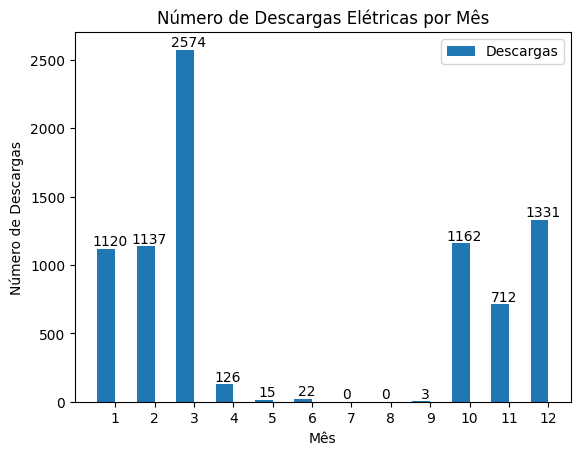

In [ ]:
def contar_descargas_por_mes(arquivo):
    descargas_por_mes = [0] * 12  # Inicializa um array para contar o número de descargas por mês

    with open(arquivo, 'r') as file:
        reader = csv.reader(file)
        next(reader, None)  # Pular cabeçalho

        for row in reader:
            if len(row) >= 10:  # Certifique-se de que a linha tem pelo menos 10 colunas (mês e polaridade)
                mes = int(row[2])  # Supondo que o mês está na segunda coluna
                if 1 <= mes <= 12:  # Garante que o valor do mês está no intervalo correto
                    descargas_por_mes[mes - 1] += 1  # Subtrai 1 para ajustar para índice 0-based

    return descargas_por_mes

# Exemplo de utilização
arquivo_csv = 'dados2017.csv'  # Substitua pelo caminho real do seu arquivo CSV
descargas_por_mes = contar_descargas_por_mes(arquivo_csv)

# Plotar gráfico de barras agrupadas
meses = list(range(1, 13))
largura_barra = 0.45  # Ajuste conforme necessário

fig, ax = plt.subplots()
barra1 = ax.bar(meses, descargas_por_mes, largura_barra, label='Descargas')

ax.set_xlabel('Mês')
ax.set_ylabel('Número de Descargas')
ax.set_title('Número de Descargas Elétricas por Mês')
ax.set_xticks(np.arange(1, 13) + largura_barra / 2)  # Ajusta a posição das barras no eixo x
ax.set_xticklabels(meses)
ax.legend()

# Adicionar rótulos acima das barras
for i, v in enumerate(descargas_por_mes):
    ax.text(i + 1 + largura_barra / 5, v + 0.1, str(v), color='black', ha='center', va='bottom')

plt.show()


Codigo que modela o grafo

In [3]:
def calcular_distancia(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

def modelar_grafo(arquivo):
    G = nx.Graph()
    contador = 0

    with open(arquivo, 'r') as file:
        reader = csv.reader(file)
        next(reader, None)  # Pular cabeçalho

        for row in reader:
            if len(row) >= 10:
                if int(row[2]) == 3:  # Verifica se o mês da descarga é igual a 3
                    coordenadas = (float(row[7]), float(row[8]))  # Coordenadas do ponto (latitude, longitude)
                    polaridade = int(row[10])  # Polaridade

                    # Adiciona o nó ao grafo com a polaridade como atributo
                    G.add_node(coordenadas, polaridade=polaridade)

    # Adiciona arestas com base nas condições
    for node1, data1 in G.nodes(data=True):
        for node2, data2 in G.nodes(data=True):
            if node1 != node2:  # Garante que não estamos conectando um nó a si mesmo
                distancia = calcular_distancia(node1, node2)
                polaridade1 = data1['polaridade']
                polaridade2 = data2['polaridade']

                if distancia < 5:
                    G.add_edge(node1, node2, distance=distancia)

    return G

arquivo_csv = 'dados2017.csv'
grafo = modelar_grafo(arquivo_csv)

#Encontrar o clique maximo
cliques_maximos = list(nx.find_cliques(grafo)) # Lista com todos os cliques maximos
cliques_maximos = [clique for clique in nx.find_cliques(grafo) if len(clique) >= 23] # Aqui ele pega apenas os cliques maximos com mais de 23 vertices
clique_maximo = max(cliques_maximos, key=len)
print("Cliques máximos encontrados:", cliques_maximos)
print("Clique máximo:", clique_maximo)
print("Tamanho do clique máximo:", len(clique_maximo))

subgrafo_maximo = grafo.subgraph(clique_maximo) # Cria um grafo com os vertices do clique maximo


Cliques máximos encontrados: [[(-19.6757, -44.60611), (-19.6734, -44.60465), (-19.68543, -44.60221), (-19.69579, -44.59779), (-19.70265, -44.59369), (-19.69908, -44.5977), (-19.68934, -44.61774), (-19.69802, -44.61868), (-19.71164, -44.60581), (-19.70302, -44.61858), (-19.70036, -44.62066), (-19.71732, -44.59685), (-19.715, -44.59179), (-19.70244, -44.57418), (-19.69366, -44.57573), (-19.7105, -44.58082), (-19.68856, -44.5827), (-19.69495, -44.58088), (-19.67582, -44.58176), (-19.67782, -44.57994), (-19.69604, -44.57695), (-19.69596, -44.57896), (-19.68601, -44.58237), (-19.69761, -44.57877)], [(-19.6757, -44.60611), (-19.6734, -44.60465), (-19.68543, -44.60221), (-19.69579, -44.59779), (-19.70265, -44.59369), (-19.69908, -44.5977), (-19.68934, -44.61774), (-19.69802, -44.61868), (-19.71164, -44.60581), (-19.70302, -44.61858), (-19.70036, -44.62066), (-19.71732, -44.59685), (-19.715, -44.59179), (-19.69729, -44.62233), (-19.68856, -44.5827), (-19.68601, -44.58237), (-19.69495, -44.5808

Encontra o nó com maior grau

In [4]:
graus = dict(grafo.degree())
no_maior_grau = max(graus, key=graus.get)
maior_grau = graus[no_maior_grau]
print(f"Nó com o maior grau: {no_maior_grau}, Grau: {maior_grau}")

Nó com o maior grau: (-19.73421, -44.59571), Grau: 60


Codigo que exporta o grafo e o clique maximo para o gephi e faz o download dos arquivos

In [ ]:
from google.colab import files
nx.write_graphml(grafo, "grafo_completo(10km).graphml")
nx.write_graphml(subgrafo_maximo, "subgrafo_maximo(10km).graphml")

files.download("grafo_completo(10km).graphml")
files.download("subgrafo_maximo(10km).graphml")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>